<a href="https://colab.research.google.com/github/stratis-forge/segmentation-workflows/blob/main/demo_DLseg_LungOAR_on_IDC_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this tutorial, we will demonstrate how to apply AI segmentation models and extract radiomic features using CERR on a cohort of patients downloaded from the  [NCI's IDC](https://portal.imaging.datacommons.cancer.gov/about/) repository.

This example uses lung CT scans of non-small cell lung cancer (NSCLC) patients from the [Lung1](https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics) dataset.


## Requirements


* GNU Octave with `statistics`, `io` & `image` packages
* CERR
* Python packages for visualization   
 *See [installation instructions](https://github.com/stratis-forge/installation-and-dependencies).*  


* A Google account  
  *Login to existing Google account or see [instructions](https://accounts.google.com/signup/v2/webcreateaccount?dsh=308321458437252901&continue=https%3A%2F%2Faccounts.google.com%2FManageAccount&flowName=GlifWebSignIn&flowEntry=SignUp#FirstName=&LastName=) to create a new account.*  




## Set up a GCP BigQuery project*




#### Activate GCP for your account and create a GCP project  
 
1.  Go to https://console.cloud.google.com/, and accept Terms and conditions.
2.  Click `Select a project` in the upper-left corner of the GCP console.
3.  Click `Create new project`.
4.  Open the GCP console menu icon `☰` and select `Dashboard` to view   information about your project. Copy your `Project ID` and insert it in place of `REPLACE_ME_WITH_YOUR_PROJECT_ID` in the cell below.   


#### Add the bigquery-public-data project
1. Open the BigQuery console: https://console.cloud.google.com/bigquery, and click the `+ ADD DATA` button.
2. Select `Star project by name` and type in `bigquery-public-data` as the project name.

**Adapted from [IDC tutorials](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part1_prerequisites.ipynb)*

## Authentication for Google services

In [1]:
# Initialize Google Cloud Project ID
my_ProjectID = "REPLACE_ME_WITH_YOUR_PROJECT_ID" #Replace with project ID 

import os
os.environ["GCP_PROJECT_ID"] = my_ProjectID

In [2]:
from google.colab import auth
auth.authenticate_user()

## Download selected cohort

Query the `idc_current` dataset and output a dataframe with URLs for patients from the `RIDER Lung CT` dataset.   

In [3]:
from google.cloud import bigquery

bq_client = bigquery.Client(my_ProjectID) # BigQuery client is initialized with 
                                          # user-input project ID  

selection_query = """
SELECT
  PatientID,
  StudyInstanceUID,
  SeriesInstanceUID,
  collection_id,
  gcs_url
FROM
  `bigquery-public-data.idc_current.dicom_all`
WHERE
  Modality = "CT"
  AND Collection_ID = "nsclc_radiomics"
"""
selection_result = bq_client.query(selection_query)
cohort_df = selection_result.result().to_dataframe()

#cohort_df
display(cohort_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51230 entries, 0 to 51229
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   PatientID          51230 non-null  object
 1   StudyInstanceUID   51230 non-null  object
 2   SeriesInstanceUID  51230 non-null  object
 3   collection_id      51230 non-null  object
 4   gcs_url            51230 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


None

We will use CT scans of a random subset of 5 patients for this demonstration

In [4]:
from pandas import pandas
import random

num_sample = 5
all_patients = set(cohort_df["PatientID"])
sample_patients = random.sample(all_patients,num_sample)
subset_df = cohort_df[cohort_df["PatientID"].isin(sample_patients)]

selected_df = pandas.DataFrame()
for patient in sample_patients:
  patient_df = subset_df[subset_df["PatientID"]==patient]
  study_uids = list(patient_df["StudyInstanceUID"].unique())
  patient_study_df = patient_df[patient_df["StudyInstanceUID"]==study_uids[0]]
  series_uids = list(patient_study_df["SeriesInstanceUID"].unique())
  patient_series_df = patient_study_df[patient_study_df["SeriesInstanceUID"]==series_uids[0]]
  patient_series_df = patient_series_df.reset_index(drop=True)
  if patient==sample_patients[0]:
    selected_df = patient_series_df
  else:
    selected_df = pandas.concat([selected_df,patient_series_df])

display(selected_df)

,PatientID,StudyInstanceUID,SeriesInstanceUID,collection_id,gcs_url
0,LUNG1-116,1.3.6.1.4.1.32722.99.99.2076605554376943463143...,1.3.6.1.4.1.32722.99.99.3292202301964767356144...,nsclc_radiomics,gs://idc-open-cr/9c3e6b91-9a9f-4488-aa90-785fb...
1,LUNG1-116,1.3.6.1.4.1.32722.99.99.2076605554376943463143...,1.3.6.1.4.1.32722.99.99.3292202301964767356144...,nsclc_radiomics,gs://idc-open-cr/d83c8990-ee94-49ec-8baf-7549b...
2,LUNG1-116,1.3.6.1.4.1.32722.99.99.2076605554376943463143...,1.3.6.1.4.1.32722.99.99.3292202301964767356144...,nsclc_radiomics,gs://idc-open-cr/13e260ab-5877-46f9-8bbb-bb266...
3,LUNG1-116,1.3.6.1.4.1.32722.99.99.2076605554376943463143...,1.3.6.1.4.1.32722.99.99.3292202301964767356144...,nsclc_radiomics,gs://idc-open-cr/4fe72045-b47b-46b2-a561-837a3...
4,LUNG1-116,1.3.6.1.4.1.32722.99.99.2076605554376943463143...,1.3.6.1.4.1.32722.99.99.3292202301964767356144...,nsclc_radiomics,gs://idc-open-cr/4ad5bcf9-a8a8-4a27-9d18-bc90f...
...,...,...,...,...,...
96,LUNG1-156,1.3.6.1.4.1.32722.99.99.2198988529717484749637...,1.3.6.1.4.1.32722.99.99.8159244901880428411584...,nsclc_radiomics,gs://idc-open-cr/9cac49ed-ef03-4fef-add2-e1e68...
97,LUNG1-156,1.3.6.1.4.1.32722.99.99.2198988529717484749637...,1.3.6.1.4.1.32722.99.99.8159244901880428411584...,nsclc_radiomics,gs://idc-open-cr/328b6fe6-b76d-452f-ac64-47816...
98,LUNG1-156,1.3.6.1.4.1.32722.99.99.2198988529717484749637...,1.3.6.1.4.1.32722.99.99.8159244901880428411584...,nsclc_radiomics,gs://idc-open-cr/5658e981-7b57-41f3-abb3-85984...
99,LUNG1-156,1.3.6.1.4.1.32722.99.99.2198988529717484749637...,1.3.6.1.4.1.32722.99.99.8159244901880428411584...,nsclc_radiomics,gs://idc-open-cr/5431e63a-a6c0-4084-9109-e8b2f...


Save URLs into a manifest file for download using `gsutil` from the Google Cloud SDK*. 

*Note: Google Cloud SDK is pre-installed on Colab, but will need to be installed if downloading directly to your computer.* 

In [5]:
%%capture
#Save URLs to manifest file
selected_df["gcs_url"].to_csv("manifest.txt", header=False, index=False)

#Download images to /content/downloaded_cohort_files
!rm -rf downloaded_cohort_files && mkdir downloaded_cohort_files
!cat manifest.txt | gsutil -m cp -I downloaded_cohort_files

## Install *DICOMSort* to organize downloaded data



In [6]:
%%capture
!git clone https://github.com/pieper/dicomsort src/dicomsort
!pip install -r /content/src/dicomsort/requirements.txt

Organize DICOM files by patient ID and modality

In [7]:
%%capture
# Run  DICOMSort 
!python src/dicomsort/dicomsort.py -u /content/downloaded_cohort_files/ /content/organized_cohort_files/dicom/%PatientID/%SOPInstanceUID.dcm

# Delete temporary directory for unsorted DICOM data 
!rm -rf /content/downloaded_cohort_files/

## Load Oct2Py and required Octave packages

In [8]:
%load_ext oct2py.ipython
from oct2py import octave

In [9]:
%%capture
%%octave
pkg load statistics
pkg load image
pkg load io

## Download and unpack pretrained model

In [10]:
%%capture
model_loc = 'https://mskcc.box.com/shared/static/31hktq1f59htjquirmvn1wk4gsdfq32k.gz'
model_dir = '/content/pretrained_model'
file_name = 'CT_LungOAR_incrMRRN.tar.gz'
model_file = model_dir + '/' + file_name
 
!mkdir $model_dir
!wget $model_loc -O $model_file
!tar -xvzf $model_file -C $model_dir

## Import data to CERR

In [11]:
%%capture
%%octave
#Add CERR to path
curr_dir = pwd()
cd('/content/CERR')
addToPath2(pwd)
cd(curr_dir)

In [12]:
%%capture
%%octave
sourceDir = '/content/organized_cohort_files/dicom'  
destDir = '/content/organized_cohort_files/cerr/'  
zipFlag = 'No';
mergeFlag = 'No';
singleCerrFileFlag = 'No';
init_ML_DICOM;
batchConvertWithSubDirs(sourceDir,destDir,zipFlag,mergeFlag,singleCerrFileFlag)

# Run segmentation model

In [13]:
%%capture
%%octave

#Run segmentation model
src_dir = '/content/organized_cohort_files/cerr';
cerr_dir = '/content/seg_results/cerr';
output_dir = '/content/seg_results/dcm';
session_dir = '/content/tmp';
cmd_flag = 'condaEnv';
new_session = true;

mkdir(cerr_dir)
mkdir(session_dir)
mkdir(output_dir)

algorithm = 'CT_LungOAR_incrMRRN';
model_dir = '/content/pretrained_model/CT_LungOAR_incrMRRN';

#Loop over CERR files
dirS = dir([src_dir,filesep,'*.mat']);
origScanNumV = nan(1,length(dirS));

for nFile = 1:length(dirS)

  # Load file
  fileName = fullfile(src_dir,dirS(nFile).name);
  planC = loadPlanC(fileName,tempdir);
  planC = updatePlanFields(planC);
  planC = quality_assure_planC(fileName,planC);

  #Run AI model
  [planC,origScanNum,allLabelNamesC,dcmExportOptS] = runAIforPlanC(planC,...
   session_dir,algorithm,cmd_flag,new_session,[],[],model_dir);

  origScanNumV(nFile) = origScanNum;
  out_path = fullfile(cerr_dir,dirS(nFile).name);

  #Save segmentation to CERR archive
  save_planC(planC,[],'PASSED',out_path);
end

#Export segmentations to DICOM
batchExportAISegToDICOM(cerr_dir,origScanNumV,allLabelNamesC,'',output_dir,...
                        dcmExportOptS,'no');

## Extract segmentation masks

In [14]:
%%capture
%%octave

%Load sample result
out_path = fullfile(cerr_dir,dirS(1).name)
planC = loadPlanC(out_path,tempdir);
planC = updatePlanFields(planC);
planC = quality_assure_planC(out_path,planC);

%Get scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
scanArray = single(getScanArray(scanNum,planC)) - ctOffset;

%Get structure labels & masks
numStructs = length(planC{indexS.structures});
structNameC = {planC{indexS.structures}.structureName};
strNameC = {'Lung_Left', 'Lung_Right', 'Heart',...
            'Esophagus', 'Cord', 'PBT'};

for strNum = 1:length(strNameC)
    searchStr = strNameC{strNum};
    idx = getMatchingIndex(searchStr,structNameC,'EXACT');
    mask3M = getStrMask(idx, planC);
    maskC{strNum} = mask3M;
end     

## Visualize results

In [15]:
%octave_pull maskC strNameC scanArray

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 255, dx)
y = np.arange(0, 255, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens,plt.cm.Reds]

clear_output(wait=True)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image


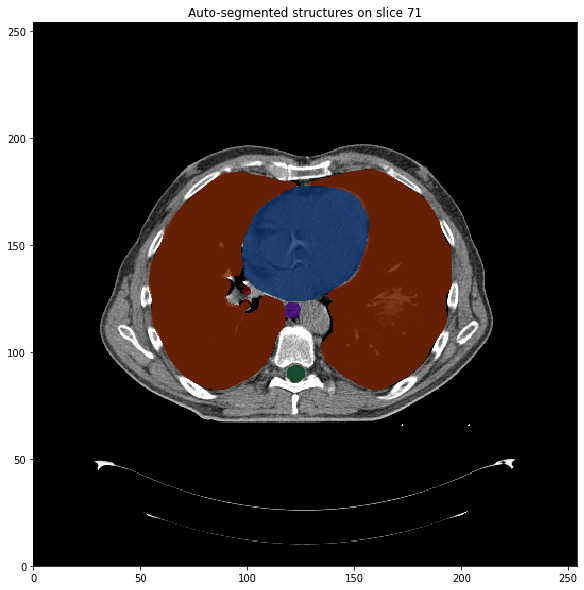

In [17]:
# Plot center slice
scanSize = np.shape(scanArray)
centerSlc = np.round(scanSize[2]/2).astype(int)

window_center = 40
window_width = 400
fig, ax = plt.subplots(1,1,figsize=(10,10))

windowed_img = window_image(scanArray[:,:,centerSlc],
                                window_center,window_width)
ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
ax.title.set_text('Auto-segmented structures on slice ' + str(centerSlc))
fontdict = {'fontsize' : 100}

for maskNum in range(0,6,1):
        mask_cmap = cmaps[maskNum].copy()
        mask_cmap.set_under('k', alpha=0)
        im2 = ax.imshow(maskC[0,maskNum][:,:,centerSlc-1], 
                        cmap=mask_cmap, alpha=.8, extent=extent,
                        interpolation='none', clim=[0.5, 1])   
